## Persiapan notebook

In [ ]:
!pip install Sastrawi==1.0.1
!pip install indonlp==0.3.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=be38ded0432148ddcc1dfecbabb598d761a266f8f6ef29fafcb7c2ba59c40853
  Stored in directory: /root/.cache/pip/wheels/d9/31/ff/ff51141a088571a9f672449e5aad5ea8bb35ca5d95ba135f30
Successfully built swifter


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Skripsi

/content/drive/MyDrive/Skripsi


## import library

In [ ]:
import pandas as pd

%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import swifter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
from wordcloud import WordCloud
from joblib import Parallel, delayed
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from indoNLP.preprocessing import replace_slang
import utils.sentimen_processing as sp
import utils.visualisation as vs

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
#inialization Steamer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

## Persiapan Dataset untuk model sentimen

### load data

In [ ]:
with open("data/stopWords.txt", "r", encoding="utf-8") as f:
    stopWords = f.read().splitlines()
print(stopWords)

['agar', 'akan', 'adalah', 'aku', 'anda', 'antar', 'asal', 'atau', 'bagi', 'bagai', 'bahwa', 'bapak', 'begini', 'berapa', 'beri', 'berupa', 'bila', 'buat', 'bung', 'cara', 'dalam', 'dan', 'dengan', 'dia', 'diri', 'ia', 'ini', 'itu', 'ibu', 'ikut', 'jika', 'kami', 'kata', 'kini', 'kok', 'kamu', 'kan', 'kapan', 'kepada', 'kita', 'maka', 'memang', 'mereka', 'mirip', 'nya', 'oleh', 'para', 'pun', 'pak', 'para', 'per', 'pihak', 'saja', 'saat', 'saya', 'sebagai', 'sebab', 'se', 'sehingga', 'serta', 'semua', 'serta', 'siap', 'supaya', 'tentang', 'toh', 'untuk', 'wahai', 'walau', 'yaitu', 'yakni', 'yang', '[hashtag]', '[url]', '[username]', 'hashtag', 'url', 'username', 'bri', 'bumn', 'unvr', 'tlkm', 'goto', 'emiten', 'ojk', 'tuck', 'kwong', 'di', 'yuk', 'ri', 'bbri', 'telkomsel', 'telkom', 'indf', 'indofood', 'indomie', 'gojek', 'grab', 'tokopedia', 'indonesia', 'asi', 'bmri', 'bnni']


In [ ]:
CNBCI = pd.read_csv("data/data_sentimen/CNBCI.csv")
CNBCI.head()

judul     tanggal sentimen
0  Direktur Garuda Salman El Farisiy Meninggal, I...  2024/01/01  negatif
1  Catatan Sejarah 2023, Indonesia Luncurkan Burs...  2024/01/01   netral
2  Ramalan Bitcoin Paling Gila 2024, Naik 1.000% ...  2024/01/01   netral
3  Wah! Segini Harta Mantan Istri Prabowo Titiek ...  2024/01/01   netral
4  Pensiun di Oktober 2024, Jokowi Kantongi Uang ...  2024/01/01   netral

In [ ]:
IDSMSA = pd.read_csv("data/data_sentimen/IDSMSA.csv")
IDSMSA.head()

Tweet Date  \
0  Thu Feb 29 11:21:27 +0000 2024   
1  Thu Feb 29 10:11:05 +0000 2024   
2  Thu Feb 29 10:06:04 +0000 2024   
3  Thu Feb 29 07:42:09 +0000 2024   
4  Thu Feb 29 06:06:17 +0000 2024   

                                            Sentence  Quote Count  \
0         Gk muluk muluk, 100,000 lot saham BBCA aja            0   
1  BCA Expoversary 2024 menawarkan promo suku bun...            0   
2             [USERNAME] saham bca nya menyusul ya 🙂            0   
3  PT Bank BCA Syariah (BCA Syariah) turut memeri...            0   
4  [USERNAME] Begitu byk saham kamu memilih saham...            0   

   Reply Count  Retweet Count  Favorite Count Sentiment  \
0            0              0               0  Positive   
1            0              0               0   Neutral   
2            0              0               0  Positive   
3            0              0               0   Neutral   
4            0              0               1  Positive   

                                 English Translation  
0  Not too ambitious, just 100,000 lots of BBCA s...  
1  BCA Expoversary 2024 offers special interest r...  
2                [USERNAME] BCA shares will follow 🙂  
3  PT Bank BCA Syariah (BCA Syariah) also enliven...  
4  [USERNAME] So many stocks you choose those sto...

In [ ]:
dasar = pd.read_csv("data/data_sentimen/sentimen_dasar.csv")
dasar.head()

Kata Sentimen
0       bagus  Positif
1       keren  Positif
2     menarik  Positif
3       hebat  Positif
4  luar biasa  Positif

In [ ]:
indolu = pd.read_csv('data/data_sentimen/train_preprocess.tsv', sep='\t', names=["text", "sentimen"])
indolu.head()

text  sentimen
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2  lokasi strategis di jalan sumatera bandung . t...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative

In [ ]:
trainJSON = pd.read_json("data/data_sentimen/train.jsonl", lines=True)
trainJSON

text  label
0     Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...      0
1     Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...      1
2     BRI dan Cita Tenun Indonesia Garap Pameran ANT...      1
3     Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...      1
4     Lampaui Target, BRI Sukses Jual SBN SR018 Hing...      2
...                                                 ...    ...
1317               Tanggapan BRI untuk Surat Bapak Ryan      1
1318  Pembakar ATM BRI Yogya Dari kelompok Narco-Pun...      0
1319  Cegah Corona Menyebar, BRI Sediakan Fasilitas ...      2
1320  Sebut 2023 Tahun Ekspansi, Dirut BRI: Jangan T...      1
1321              Klaim Pendebetan BRI Belum Ada Solusi      0

[1322 rows x 2 columns]

In [ ]:
testJSON = pd.read_json("data/data_sentimen/test.jsonl", lines=True)
testJSON

text  label
0    Polisi Tangkap 4 WNA dan 1 WNI Pelaku Skimming...      0
1    BRI: Tak Benar Ada Pegawai Kena Virus Korona, ...      1
2    Penuhi Ekspektasi Nasabah, BRI Sabet 2 Penghar...      2
3                BRI Mau Buyback Saham Rp 1,5 Triliun!      1
4    Virtual Coaching, Cara BRI Bina Pelaku UMKM Sa...      2
..                                                 ...    ...
647  Sinergi MIND ID dan BRI Demi Optimalisasi Liku...      1
648  Profil Awan Nurmawan Nuh, Irjen Kemenkeu yang ...      1
649  Polisi Magelang Ungkap Korupsi KUR BRI Bernila...      0
650  BRI-Ditjen Pajak Jalin Kerja Sama Implementasi...      1
651  Dengan KUR, BRI Bantu UMKM di Labuan Bajo Naik...      2

[652 rows x 2 columns]

In [ ]:
jsonDF = pd.concat([trainJSON, testJSON], ignore_index=True)
jsonDF

text  label
0     Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...      0
1     Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...      1
2     BRI dan Cita Tenun Indonesia Garap Pameran ANT...      1
3     Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...      1
4     Lampaui Target, BRI Sukses Jual SBN SR018 Hing...      2
...                                                 ...    ...
1969  Sinergi MIND ID dan BRI Demi Optimalisasi Liku...      1
1970  Profil Awan Nurmawan Nuh, Irjen Kemenkeu yang ...      1
1971  Polisi Magelang Ungkap Korupsi KUR BRI Bernila...      0
1972  BRI-Ditjen Pajak Jalin Kerja Sama Implementasi...      1
1973  Dengan KUR, BRI Bantu UMKM di Labuan Bajo Naik...      2

[1974 rows x 2 columns]

### menyamakan kolom untuk digabungkan

In [ ]:
mapping = {2: "positif", 0 : "negatif", 1 : "netral"}

In [ ]:
jsonDF["sentimen"] = jsonDF["label"].map(mapping)
jsonDF

text  label sentimen
0     Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...      0  negatif
1     Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...      1   netral
2     BRI dan Cita Tenun Indonesia Garap Pameran ANT...      1   netral
3     Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...      1   netral
4     Lampaui Target, BRI Sukses Jual SBN SR018 Hing...      2  positif
...                                                 ...    ...      ...
1969  Sinergi MIND ID dan BRI Demi Optimalisasi Liku...      1   netral
1970  Profil Awan Nurmawan Nuh, Irjen Kemenkeu yang ...      1   netral
1971  Polisi Magelang Ungkap Korupsi KUR BRI Bernila...      0  negatif
1972  BRI-Ditjen Pajak Jalin Kerja Sama Implementasi...      1   netral
1973  Dengan KUR, BRI Bantu UMKM di Labuan Bajo Naik...      2  positif

[1974 rows x 3 columns]

In [ ]:
json_new = jsonDF[['text','sentimen']]
json_new.head()

text sentimen
0  Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...  negatif
1  Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...   netral
2  BRI dan Cita Tenun Indonesia Garap Pameran ANT...   netral
3  Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...   netral
4  Lampaui Target, BRI Sukses Jual SBN SR018 Hing...  positif

In [ ]:
CNBCI_new = CNBCI[['judul','sentimen']].rename(columns={'judul':'text','Sentimen':'sentimen'})
CNBCI_new.head()

text sentimen
0  Direktur Garuda Salman El Farisiy Meninggal, I...  negatif
1  Catatan Sejarah 2023, Indonesia Luncurkan Burs...   netral
2  Ramalan Bitcoin Paling Gila 2024, Naik 1.000% ...   netral
3  Wah! Segini Harta Mantan Istri Prabowo Titiek ...   netral
4  Pensiun di Oktober 2024, Jokowi Kantongi Uang ...   netral

In [ ]:
IDSMSA_new = IDSMSA[['Sentence','Sentiment']].rename(columns={'Sentence':'text','Sentiment':'sentimen'})
IDSMSA_new.head()

text  sentimen
0         Gk muluk muluk, 100,000 lot saham BBCA aja  Positive
1  BCA Expoversary 2024 menawarkan promo suku bun...   Neutral
2             [USERNAME] saham bca nya menyusul ya 🙂  Positive
3  PT Bank BCA Syariah (BCA Syariah) turut memeri...   Neutral
4  [USERNAME] Begitu byk saham kamu memilih saham...  Positive

In [ ]:
dasar_new = dasar[['Kata','Sentimen']].rename(columns={'Kata':'text','Sentimen':'sentimen'})
dasar_new.head()

text sentimen
0       bagus  Positif
1       keren  Positif
2     menarik  Positif
3       hebat  Positif
4  luar biasa  Positif

In [ ]:
print(indolu['sentimen'].value_counts())

sentimen
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64


In [ ]:
positive_sample = indolu[indolu["sentimen"] == "positive"].sample(n=2000, random_state=42)

negative_sample = indolu[indolu["sentimen"] == "negative"]
neutral_sample  = indolu[indolu["sentimen"] == "neutral"]

indoluDF = pd.concat([positive_sample, negative_sample, neutral_sample])

indoluDF = indoluDF.sample(frac=1, random_state=42).reset_index(drop=True)

print(indoluDF["sentimen"].value_counts())
indolu.head()

sentimen
negative    3436
positive    2000
neutral     1148
Name: count, dtype: int64


text  sentimen
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2  lokasi strategis di jalan sumatera bandung . t...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative

In [ ]:
sentimenDF = pd.concat([json_new, CNBCI_new, IDSMSA_new, dasar_new, indoluDF], ignore_index=True)
sentimenDF

text  sentimen
0      Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...   negatif
1      Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...    netral
2      BRI dan Cita Tenun Indonesia Garap Pameran ANT...    netral
3      Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...    netral
4      Lampaui Target, BRI Sukses Jual SBN SR018 Hing...   positif
...                                                  ...       ...
21676  katakan tidak untuk gerindra . mereka akan men...  negative
21677  walaupun lokasi yang strategis variasi menu ma...  negative
21678  menyakitkan adalah ketika gue cemburu sama lo ...  negative
21679  andai saja memukul orang itu bukan tindakan kr...  negative
21680  makanan di padma mantaps banget . wok vegetabl...  positive

[21681 rows x 2 columns]

### menghilangkan duplikasi dan data kosong

In [ ]:
sentimenDF.duplicated().sum()

np.int64(144)

In [ ]:
sentimenDF.isna().sum()

text        0
sentimen    0
dtype: int64

In [ ]:
sentimenDF.dropna(inplace=True)
sentimenDF.drop_duplicates(inplace=True)
sentimenDF.duplicated().sum()

np.int64(0)

In [ ]:
sentimenDF.sentimen.unique()

array(['negatif', 'netral', 'positif', 'Positive', 'Neutral', 'Negative',
       'Positif', 'Negatif', 'Netral', 'positive', 'negative', 'neutral'],
      dtype=object)

In [ ]:
print(sentimenDF['sentimen'].value_counts())

sentimen
netral      4849
positif     3734
negative    3412
negatif     2945
positive    1999
Positive    1746
neutral     1138
Negative     779
Neutral      729
Negatif       72
Positif       70
Netral        64
Name: count, dtype: int64


### mapping untuk mengubah label sentimen menjadi angka

In [ ]:
mapping_label = {"positif": 2, "negatif": 0, "netral": 1,
           "positive": 2, "negative": 0, "neutral": 1
           }

In [ ]:
sentimenDF["label"] = sentimenDF["sentimen"].str.lower().map(mapping_label)
sentimenDF

text  sentimen  label
0      Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...   negatif      0
1      Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...    netral      1
2      BRI dan Cita Tenun Indonesia Garap Pameran ANT...    netral      1
3      Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...    netral      1
4      Lampaui Target, BRI Sukses Jual SBN SR018 Hing...   positif      2
...                                                  ...       ...    ...
21676  katakan tidak untuk gerindra . mereka akan men...  negative      0
21677  walaupun lokasi yang strategis variasi menu ma...  negative      0
21678  menyakitkan adalah ketika gue cemburu sama lo ...  negative      0
21679  andai saja memukul orang itu bukan tindakan kr...  negative      0
21680  makanan di padma mantaps banget . wok vegetabl...  positive      2

[21537 rows x 3 columns]

In [ ]:
print(sentimenDF['label'].value_counts())

label
2    7549
0    7208
1    6780
Name: count, dtype: int64


### visualisasi data sentimen

<Axes: xlabel='label'>

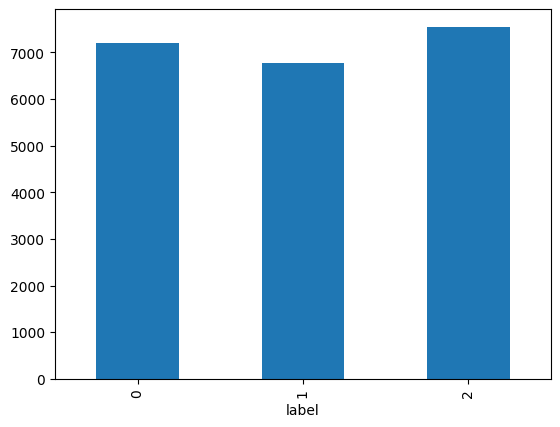

In [ ]:
sentimenDF.groupby('label').size().plot(kind='bar')

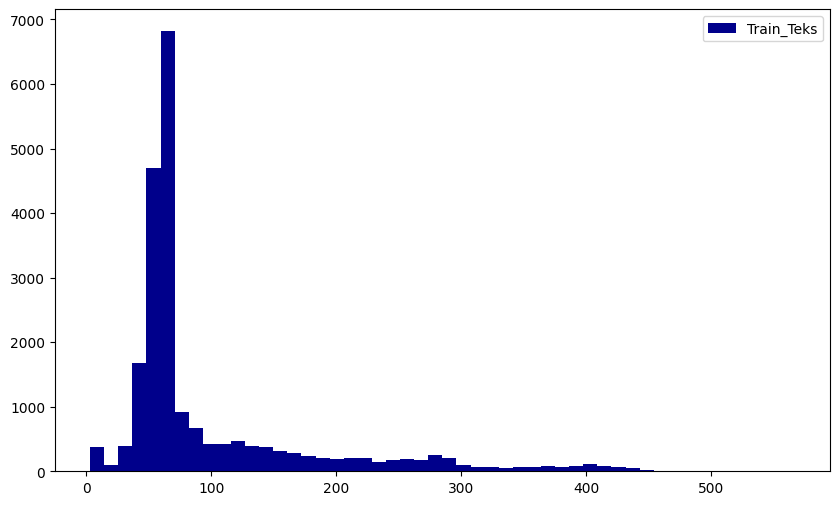

In [ ]:
# Melihat panjang teks dalam data train dan data test

length_train = sentimenDF['text'].str.len()
plt.figure(figsize=(10,6))
plt.hist(length_train, bins=50, label="Train_Teks", color = "darkblue")
plt.legend()

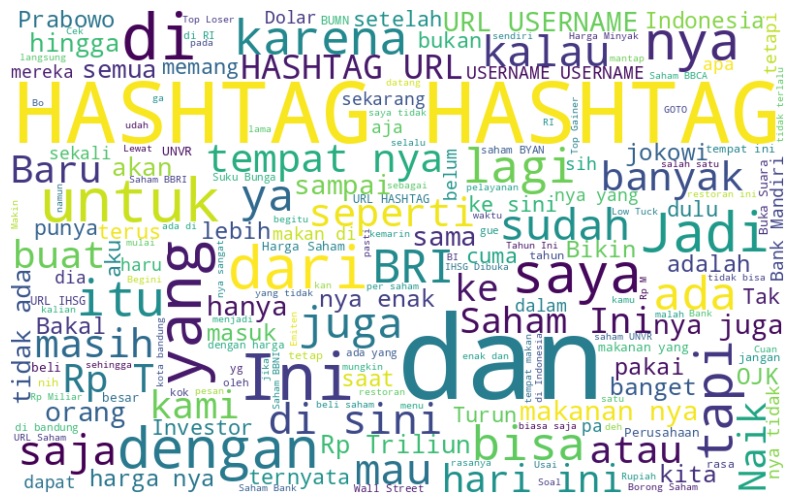

In [ ]:
# Sentimen yang ada pada seluruh data train dapat dilihat dengan memahami kata yang umum dengan plot word cloud

def wordCloud(words):
    wordCloud = WordCloud(width=800, height=500, background_color='white', random_state=21, max_font_size=120).generate(words)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')

all_words = ' '.join([text for text in sentimenDF['text']])
wordCloud(all_words)

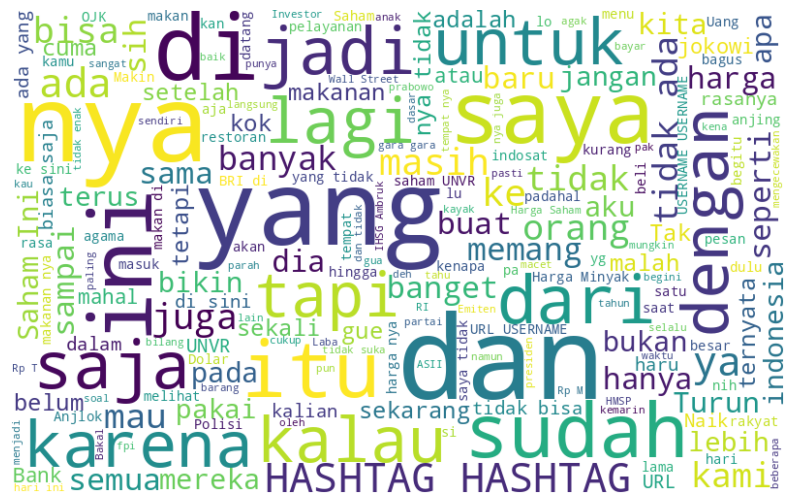

In [ ]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in sentimenDF['text'][sentimenDF['label'] == 0])
wordCloud(negative_words)

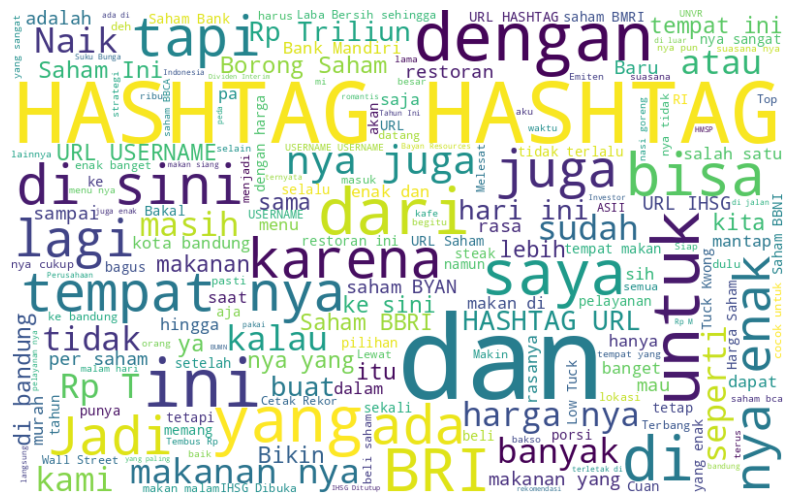

In [ ]:
# Melihat kata-kata yang positif
positive_words = ' '.join(text for text in sentimenDF['text'][sentimenDF['label'] == 2])
wordCloud(positive_words)

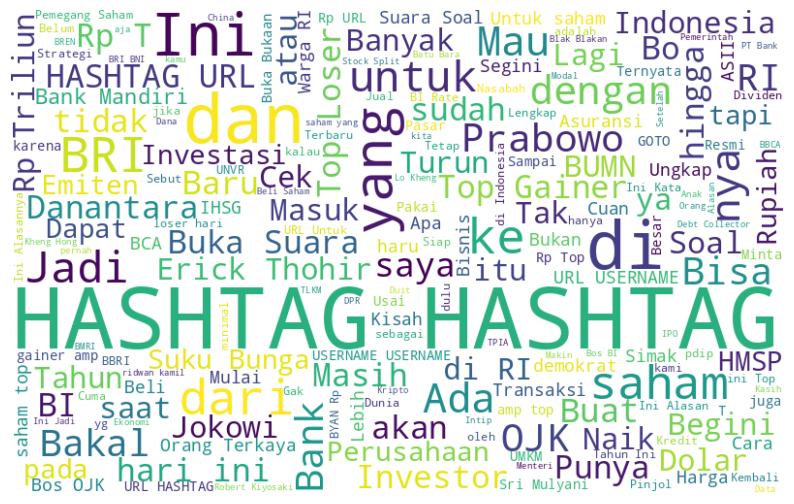

In [ ]:
# Melihat kata-kata yang netral
neutral_words = ' '.join(text for text in sentimenDF['text'][sentimenDF['label'] == 1])
wordCloud(neutral_words)

### preprocessing data

In [ ]:
sentimenDF['clean_text'] = sp.preprocess_df(sentimenDF['text'])

In [ ]:
sentimenDF

text  sentimen  label  \
0      Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...   negatif      0   
1      Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...    netral      1   
2      BRI dan Cita Tenun Indonesia Garap Pameran ANT...    netral      1   
3      Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...    netral      1   
4      Lampaui Target, BRI Sukses Jual SBN SR018 Hing...   positif      2   
...                                                  ...       ...    ...   
21676  katakan tidak untuk gerindra . mereka akan men...  negative      0   
21677  walaupun lokasi yang strategis variasi menu ma...  negative      0   
21678  menyakitkan adalah ketika gue cemburu sama lo ...  negative      0   
21679  andai saja memukul orang itu bukan tindakan kr...  negative      0   
21680  makanan di padma mantaps banget . wok vegetabl...  positive      2   

                                              clean_text  
0      kenalin ini rika  teller bri yang nyikat uang ...  
1      kepo prospek umkm? yuk daftar bri microfinance...  
2      bri dan cita tenun indonesia garap pameran ant...  
3      dirut bri  <num> jadi tahun ekspansi  masyarak...  
4      lampaui target  bri sukses jual sbn sr<num> hi...  
...                                                  ...  
21676  katakan tidak untuk gerindra   mereka akan men...  
21677  walaupun lokasi yang strategis variasi menu ma...  
21678  menyakitkan adalah ketika gue cemburu sama lo ...  
21679  andai saja memukul orang itu bukan tindakan kr...  
21680  makanan di padma mantaps banget   wok vegetabl...  

[21537 rows x 4 columns]

In [ ]:
sentimenDF["text_final"] = sentimenDF["clean_text"].swifter.apply(sp.preprocess_final)

Pandas Apply:   0%|          | 0/21537 [00:00<?, ?it/s]

In [ ]:
sentimenDF

text  sentimen  label  \
0      Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...   negatif      0   
1      Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...    netral      1   
2      BRI dan Cita Tenun Indonesia Garap Pameran ANT...    netral      1   
3      Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...    netral      1   
4      Lampaui Target, BRI Sukses Jual SBN SR018 Hing...   positif      2   
...                                                  ...       ...    ...   
21676  katakan tidak untuk gerindra . mereka akan men...  negative      0   
21677  walaupun lokasi yang strategis variasi menu ma...  negative      0   
21678  menyakitkan adalah ketika gue cemburu sama lo ...  negative      0   
21679  andai saja memukul orang itu bukan tindakan kr...  negative      0   
21680  makanan di padma mantaps banget . wok vegetabl...  positive      2   

                                              clean_text  \
0      kenalin ini rika  teller bri yang nyikat uang ...   
1      kepo prospek umkm? yuk daftar bri microfinance...   
2      bri dan cita tenun indonesia garap pameran ant...   
3      dirut bri  <num> jadi tahun ekspansi  masyarak...   
4      lampaui target  bri sukses jual sbn sr<num> hi...   
...                                                  ...   
21676  katakan tidak untuk gerindra   mereka akan men...   
21677  walaupun lokasi yang strategis variasi menu ma...   
21678  menyakitkan adalah ketika gue cemburu sama lo ...   
21679  andai saja memukul orang itu bukan tindakan kr...   
21680  makanan di padma mantaps banget   wok vegetabl...   

                                              text_final  
0      kenal rika teller nyikat uang nasabah rp num m...  
1      kepo prospek umkm daftar microfinance outlook num  
2                        cita tenun garap pamer antologi  
3      dirut num jadi tahun ekspansi masyarakat janga...  
4      lampau target sukses jual sbn sr num hingga rp...  
...                                                  ...  
21676  kata tidak gerindra jadi zombie menghisap dana...  
21677  walaupun lokasi strategis variasi menu makan k...  
21678  sakit ketika gue cemburu sama lo tapi gue cuma...  
21679  andai pukul orang bukan tindak kriminal pasti ...  
21680  makan padma mantaps banget wok vegetable segar...  

[21537 rows x 5 columns]

In [ ]:
sentimenDF.isna().sum()

text          0
sentimen      0
label         0
clean_text    0
text_final    0
dtype: int64

In [ ]:
print(sentimenDF['label'].value_counts())

label
2    7549
0    7208
1    6780
Name: count, dtype: int64


### visualisasi setelah hasil preprocessing

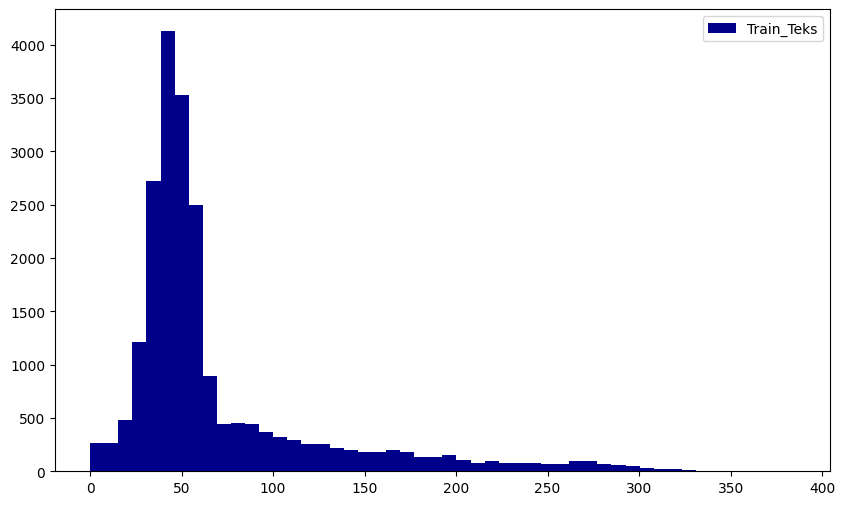

In [ ]:
# Melihat panjang teks dalam data train dan data test

length_train = sentimenDF['text_final'].str.len()
plt.figure(figsize=(10,6))
plt.hist(length_train, bins=50, label="Train_Teks", color = "darkblue")
plt.legend()

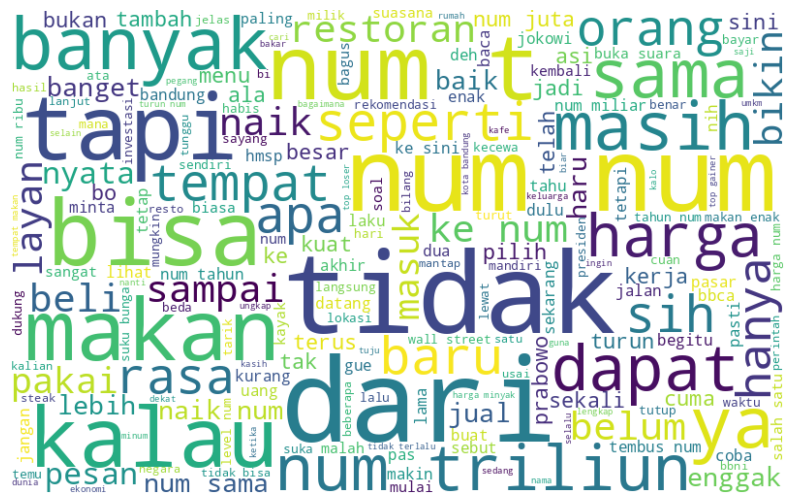

In [ ]:
all_words = ' '.join([text for text in sentimenDF['text_final']])
wordCloud(all_words)

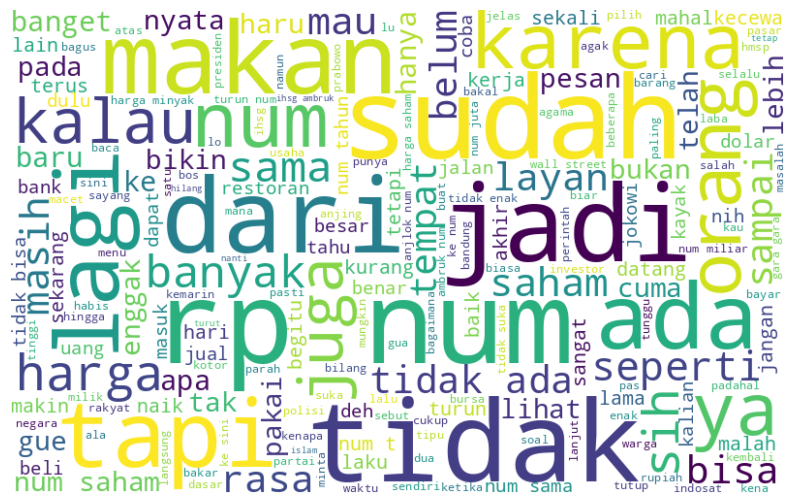

In [ ]:
# Melihat kata-kata yang negatif
negative_words = ' '.join(text for text in sentimenDF['text_final'][sentimenDF['label'] == 0])
wordCloud(negative_words)

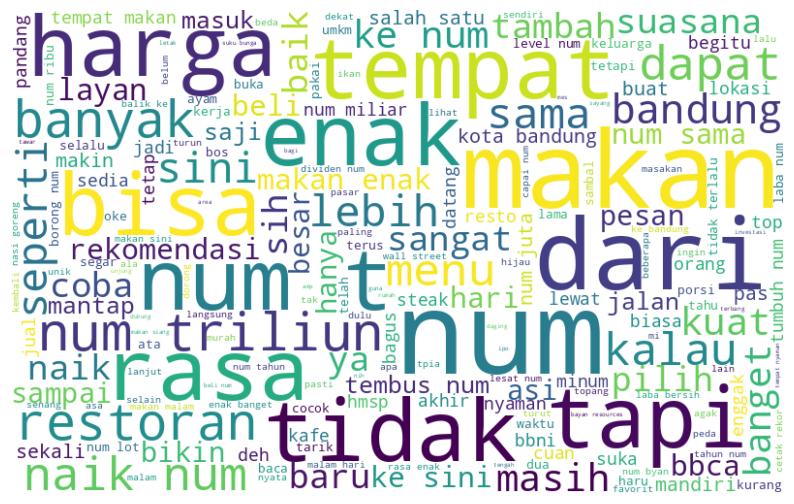

In [ ]:
# Melihat kata-kata yang positif
positive_words = ' '.join(text for text in sentimenDF['text_final'][sentimenDF['label'] == 2])
wordCloud(positive_words)

### simpan data hasil akhir preprocessing

In [ ]:
sentimenDF.to_csv("data/data_sentimen/sentimen_bersih.csv", index=False)

In [ ]:
sentimenDF = pd.read_csv("data/data_sentimen/sentimen_bersih.csv")
sentimenDF

text  sentimen  label  \
0      Kenalin Ini Rika, Teller BRI yang Nyikat Uang ...   negatif      0   
1      Kepo Prospek UMKM? Yuk Daftar BRI Microfinance...    netral      1   
2      BRI dan Cita Tenun Indonesia Garap Pameran ANT...    netral      1   
3      Dirut BRI: 2023 Jadi Tahun Ekspansi, Masyaraka...    netral      1   
4      Lampaui Target, BRI Sukses Jual SBN SR018 Hing...   positif      2   
...                                                  ...       ...    ...   
21532  katakan tidak untuk gerindra . mereka akan men...  negative      0   
21533  walaupun lokasi yang strategis variasi menu ma...  negative      0   
21534  menyakitkan adalah ketika gue cemburu sama lo ...  negative      0   
21535  andai saja memukul orang itu bukan tindakan kr...  negative      0   
21536  makanan di padma mantaps banget . wok vegetabl...  positive      2   

                                              clean_text  \
0      kenalin ini rika  teller bri yang nyikat uang ...   
1      kepo prospek umkm? yuk daftar bri microfinance...   
2      bri dan cita tenun indonesia garap pameran ant...   
3      dirut bri  <num> jadi tahun ekspansi  masyarak...   
4      lampaui target  bri sukses jual sbn sr<num> hi...   
...                                                  ...   
21532  katakan tidak untuk gerindra   mereka akan men...   
21533  walaupun lokasi yang strategis variasi menu ma...   
21534  menyakitkan adalah ketika gue cemburu sama lo ...   
21535  andai saja memukul orang itu bukan tindakan kr...   
21536  makanan di padma mantaps banget   wok vegetabl...   

                                              text_final  
0      kenal rika teller nyikat uang nasabah rp num m...  
1      kepo prospek umkm daftar microfinance outlook num  
2                        cita tenun garap pamer antologi  
3      dirut num jadi tahun ekspansi masyarakat janga...  
4      lampau target sukses jual sbn sr num hingga rp...  
...                                                  ...  
21532  kata tidak gerindra jadi zombie menghisap dana...  
21533  walaupun lokasi strategis variasi menu makan k...  
21534  sakit ketika gue cemburu sama lo tapi gue cuma...  
21535  andai pukul orang bukan tindak kriminal pasti ...  
21536  makan padma mantaps banget wok vegetable segar...  

[21537 rows x 5 columns]

### Pembagian Dataset

In [ ]:
train_data, temp_data = train_test_split(
    sentimenDF,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=sentimenDF["label"]
)

In [ ]:
val_data, test_data = train_test_split(
    temp_data,
    test_size=0.4,
    random_state=42,
    shuffle=True,
    stratify=temp_data["label"]
)

In [ ]:
print("Jumlah data train:", len(train_data))
print(train_data['label'].value_counts())
print("Jumlah data validasi:", len(val_data))
print(val_data['label'].value_counts())
print("Jumlah data test:", len(test_data))
print(test_data['label'].value_counts())

Jumlah data train: 17229
label
2    6039
0    5766
1    5424
Name: count, dtype: int64
Jumlah data validasi: 2584
label
2    906
0    865
1    813
Name: count, dtype: int64
Jumlah data test: 1724
label
2    604
0    577
1    543
Name: count, dtype: int64


### Mengubah dataset ke bentuk TF dataset

In [ ]:
def tf_dataset(dataframe, shuffle=True):
    texts = dataframe["text_final"].astype(str).values
    labels = dataframe["label"].astype("int32").values

    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(dataframe), seed=42)
    return dataset

In [ ]:
train_ds = tf_dataset(train_data, shuffle=True)
val_ds   = tf_dataset(val_data, shuffle=False)
test_ds  = tf_dataset(test_data, shuffle=False)

In [ ]:
for text, label in train_ds.take(3).as_numpy_iterator():
    print("text:", text)
    print("label:", label)

text: b'manajemen bren buka suara soal harga anjlok depak ftse'
label: 1
text: b'cetak sejarah nilai right issue num triliun tinggi asia tenggara'
label: 2
text: b'driver fase gps pakai mod jarak parah'
label: 0


In [ ]:
for text, label in test_ds.take(3).as_numpy_iterator():
    print("text:", text)
    print("label:", label)

In [ ]:
print(f"Total data train : {train_ds.cardinality()}")
print(f"Total data validation : {val_ds.cardinality()}")
print(f"Total data test : {test_ds.cardinality()}")

Total data train : 17229
Total data validation : 2584
Total data test : 1724


### proses vektorisasi

In [ ]:
maxLeght = 100
def fitVectorizer(trainSentences):
    vectorizer = tf.keras.layers.TextVectorization(
      standardize='lower_and_strip_punctuation',
      output_mode='int',
      output_sequence_length=maxLeght
    )

    vectorizer.adapt(trainSentences)
    return vectorizer

In [ ]:
textDataset = train_ds.map(lambda texts, labels: texts)
vectorizer = fitVectorizer(textDataset)
vocabSize = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocabSize} words")

Vocabulary contains 13404 words


In [ ]:
vocab = vectorizer.get_vocabulary()
print("Vocabulary:", vocab)
print("Vocabulary size:", len(vocab))

Vocabulary: ['', '[UNK]', np.str_('num'), np.str_('tidak'), np.str_('makan'), np.str_('ke'), np.str_('dari'), np.str_('harga'), np.str_('tempat'), np.str_('enak'), np.str_('sama'), np.str_('bisa'), np.str_('tapi'), np.str_('banyak'), np.str_('buka'), np.str_('rasa'), np.str_('orang'), np.str_('naik'), np.str_('tahun'), np.str_('kalau'), np.str_('hari'), np.str_('sangat'), np.str_('banget'), np.str_('baru'), np.str_('layan'), np.str_('lebih'), np.str_('t'), np.str_('sini'), np.str_('masih'), np.str_('dapat'), np.str_('ya'), np.str_('beli'), np.str_('menu'), np.str_('pilih'), np.str_('asing'), np.str_('kuat'), np.str_('bandung'), np.str_('baik'), np.str_('uang'), np.str_('sih'), np.str_('bos'), np.str_('besar'), np.str_('turun'), np.str_('cukup'), np.str_('triliun'), np.str_('kerja'), np.str_('apa'), np.str_('bikin'), np.str_('seperti'), np.str_('sampai'), np.str_('jalan'), np.str_('masuk'), np.str_('restoran'), np.str_('biasa'), np.str_('bi'), np.str_('byan'), np.str_('telah'), np.str_(

### mapping vektorisasi dan pembentukan batch

In [ ]:
batch_size = 32

train_batch = train_ds.map(lambda x, y: (vectorizer(x), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_batch   = val_ds.map(lambda x, y: (vectorizer(x), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_batch  = test_ds.map(lambda x, y: (vectorizer(x), y)).batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [ ]:
print(f"Total train Batch: {train_batch.cardinality()}")
print(f"Total validation Batch: {val_batch.cardinality()}")
print(f"Total test Batch: {test_batch.cardinality()}")

Total train Batch: 539
Total validation Batch: 81
Total test Batch: 54


In [ ]:
trainBatch = next(train_batch.as_numpy_iterator())

print(f"Shape dataset: {trainBatch[0].shape}")

Shape dataset: (32, 100)


In [ ]:
for text, label in train_batch.take(5):
    print("Sample text:", text.numpy())
    print("Sample label:", label.numpy())

Sample text: [[2530  540 4722 ...    0    0    0]
 [ 355   23  767 ...    0    0    0]
 [2802   59  151 ...    0    0    0]
 ...
 [ 737  472 1494 ...    0    0    0]
 [1816  984   90 ...    0    0    0]
 [1911  406    2 ...    0    0    0]]
Sample label: [0 1 2 2 2 1 2 1 1 0 2 0 2 2 0 0 0 2 2 1 1 0 1 0 1 2 2 1 2 0 0 2]
Sample text: [[  14    3   58 ...    0    0    0]
 [ 261 1428  537 ...    0    0    0]
 [ 532 3125  819 ...    0    0    0]
 ...
 [5451 5920  236 ...    0    0    0]
 [   2 1011    2 ...    0    0    0]
 [2709  411  432 ...    0    0    0]]
Sample label: [1 0 1 0 2 0 0 2 2 1 2 2 2 1 1 0 0 0 1 2 0 1 0 1 0 1 2 1 2 1 0 0]
Sample text: [[1855  311 3049 ...    0    0    0]
 [  38  576   95 ...    0    0    0]
 [  62  710  654 ...    0    0    0]
 ...
 [  25  400  400 ...    0    0    0]
 [ 102  114   48 ...    0    0    0]
 [ 139   13   16 ...    0    0    0]]
Sample label: [2 1 2 1 2 0 2 1 0 1 2 0 2 2 1 0 0 1 1 1 2 1 2 2 1 2 1 1 0 1 1 0]
Sample text: [[ 104   63  384 ...    

### simpan tf dataset dan vocabularity

In [ ]:
with open("data/vectorizer_vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

In [ ]:
tf.data.Dataset.save(train_ds, "data/tf_data/train_ds")
tf.data.Dataset.save(val_ds, "data/tf_data/val_ds")
tf.data.Dataset.save(test_ds, "data/tf_data/test_ds")

tf.data.Dataset.save(train_batch, "data/tf_data/train_batch")
tf.data.Dataset.save(val_batch, "data/tf_data/val_batch")
tf.data.Dataset.save(test_batch, "data/tf_data/test_batch")

## Permodelan

### load data dan vocab

In [ ]:
with open("data/vectorizer_vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

# buat ulang vectorizer
vectorizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    vocabulary=vocab
)

vocabs = vectorizer.get_vocabulary()
print("Vocabulary:", vocabs)
print("Vocabulary size:", len(vocabs))

Vocabulary: ['', '[UNK]', np.str_('num'), np.str_('saham'), np.str_('rp'), np.str_('tidak'), np.str_('makan'), np.str_('ke'), np.str_('jadi'), np.str_('ada'), np.str_('dari'), np.str_('harga'), np.str_('ihsg'), np.str_('bank'), np.str_('tempat'), np.str_('enak'), np.str_('sama'), np.str_('sudah'), np.str_('bisa'), np.str_('juga'), np.str_('tapi'), np.str_('banyak'), np.str_('buka'), np.str_('rasa'), np.str_('lagi'), np.str_('orang'), np.str_('naik'), np.str_('karena'), np.str_('tahun'), np.str_('mau'), np.str_('kalau'), np.str_('hari'), np.str_('sangat'), np.str_('banget'), np.str_('pada'), np.str_('baru'), np.str_('layan'), np.str_('lebih'), np.str_('t'), np.str_('sini'), np.str_('masih'), np.str_('dapat'), np.str_('ya'), np.str_('beli'), np.str_('menu'), np.str_('pilih'), np.str_('asing'), np.str_('kuat'), np.str_('bandung'), np.str_('baik'), np.str_('uang'), np.str_('sih'), np.str_('bos'), np.str_('besar'), np.str_('turun'), np.str_('cukup'), np.str_('triliun'), np.str_('kerja'), np

In [ ]:
train_ds = tf.data.Dataset.load("data/tf_data/train_ds")
val_ds = tf.data.Dataset.load("data/tf_data/val_ds")
test_ds = tf.data.Dataset.load("data/tf_data/test_ds")

train_batch = tf.data.Dataset.load("data/tf_data/train_batch")
val_batch = tf.data.Dataset.load("data/tf_data/val_batch")
test_batch = tf.data.Dataset.load("data/tf_data/test_batch")

### pembentukan model sentimen

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(None,), dtype=tf.int64),
    tf.keras.layers.Embedding(input_dim=vectorizer.vocabulary_size(), output_dim=64),
    tf.keras.layers.SpatialDropout1D(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False, dropout=0.5)),
    tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation="softmax")
])

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 64)       │       858,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, None, 64)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 885,507 (3.38 MB)

 Trainable params: 885,507 (3.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="model/model_sentimen_train.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')

        if train_acc >= 0.8 and val_acc >= 0.78:
            self.model.stop_training = True

### training model

In [ ]:
train_batch_ds = train_batch.shuffle(buffer_size=len(train_batch), seed=42).prefetch(tf.data.AUTOTUNE)
val_batch_ds = val_batch.prefetch(tf.data.AUTOTUNE)

In [ ]:
history = model.fit(
    train_batch_ds, epochs=100,
    validation_data=val_batch_ds,
    callbacks=[myCallback(), earlystop, checkpoint, lr_scheduler]
    )

Epoch 1/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4271 - loss: 1.2090 - val_accuracy: 0.7264 - val_loss: 0.6977 - learning_rate: 0.0010
Epoch 2/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7431 - loss: 0.6913 - val_accuracy: 0.7682 - val_loss: 0.6016 - learning_rate: 0.0010
Epoch 3/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8007 - loss: 0.5622 - val_accuracy: 0.7790 - val_loss: 0.5780 - learning_rate: 0.0010
Epoch 4/100
539/539 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.8414 - loss: 0.4889 - val_accuracy: 0.7844 - val_loss: 0.5927 - learning_rate: 0.0010


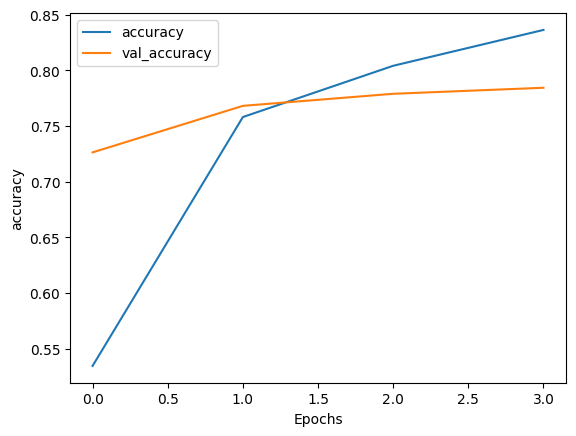

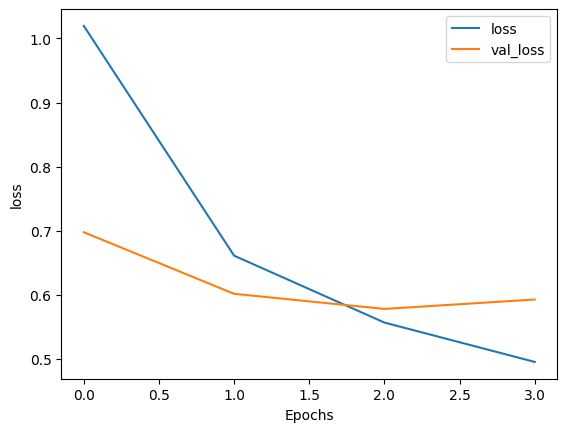

In [ ]:
vs.plotGraphsVal(history, "accuracy")
vs.plotGraphsVal(history, "loss")

### evaluasi model

In [ ]:
model.evaluate(test_batch)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8187 - loss: 0.5001


[0.5394161939620972, 0.8016241192817688]

In [ ]:
y_true = np.concatenate([y.numpy().ravel() for x, y in test_ds], axis=0)

y_pred_prob = model.predict(test_batch)

y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_true, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
              precision    recall  f1-score   support

           0     0.8150    0.8094    0.8122       577
           1     0.8072    0.7403    0.7723       543
           2     0.7856    0.8493    0.8162       604

    accuracy                         0.8016      1724
   macro avg     0.8026    0.7997    0.8002      1724
weighted avg     0.8023    0.8016    0.8010      1724

Confusion Matrix:
 [[467  52  58]
 [ 59 402  82]
 [ 47  44 513]]


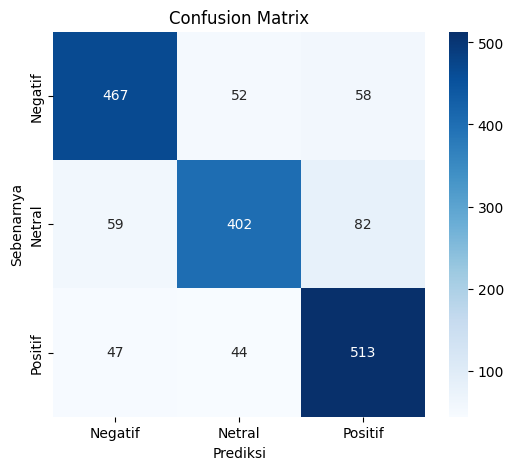

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Label kelas (misalnya 3 kelas: Negatif=0, Netral=1, Positif=2)
labels = ["Negatif", "Netral", "Positif"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Prediksi")
plt.ylabel("Sebenarnya")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
inputA = vectorizer(["mahal"])
y_pred = model.predict(inputA)
y = np.argmax(y_pred, axis=1)
print(y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
[0]


In [ ]:
model.save("model/model_sentimen.h5")

In [ ]:
model.save("model/model_sentimen.keras")

In [ ]:
model = tf.keras.models.load_model("model/model_sentimen.h5")